# Wasserstein GAN with Gradient Penalty (WGAN-GP)

## Theory

GANs are powerful generative models, but suffer from training instability. The recently proposed WGAN makes progress toward stable training of GANs, but sometimes can still generate only poor samples or fail to converge. 

These problems are often due to the use of weight clipping in WGAN to enforce a Lipschitz constraint on the critic, which can lead to undesired behavior. 

An alternative to clipping weights: **penalize the norm of gradient of the critic with respect to its input**.

$$L = \mathbb{E}_{\tilde{x} \sim \mathbb{P}_g} [D(\tilde{x})] - \mathbb{E}_{x \sim \mathbb{P}_r} [D(x)] + \lambda \mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}} [(\lVert \nabla_{\hat{x}} D(\hat{x}) \rVert_2 - 1)^2]$$

## Advantages and Limitations

+ Enables stable training of a wide variety of GAN architectures with almost no hyperparameter tuning;
+ High quality generations.


## References

I. Gulrajani, et al., Improved Training of Wasserstein GANs, NIPS 2018.

H. Petzka et al., On the Regularization of Wasserstein GANs, ICLR 2018.

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
Z_dim = 100
h_dim = 128

lr = 1e-4
lamb = 10
d_steps = 5

+ Initialization

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

+ Latent/hidden variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $G$ and Discriminator $D$ are two networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, Two-Layer Full-Connected Forward Feedback NN.

In [7]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    
    return G_prob

def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    
    return D_logit

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
G_sample = generator(Z)

D_real = discriminator(X)
D_fake = discriminator(G_sample)

+ Gradient Penalty

In [10]:
eps = tf.random_uniform([mb_size, 1], minval=0., maxval=1.)
X_inter = eps*X + (1. - eps)*G_sample
grad = tf.gradients(discriminator(X_inter), [X_inter])[0]
grad_norm = tf.sqrt(tf.reduce_sum((grad)**2, axis=1))
grad_pen = lamb * tf.reduce_mean((grad_norm - 1)**2)

+ Loss functions: Wasserstein distance with gradient penalty.
+ Instead of RMSProp in WGAN, the WGAN-GP uses the Adam version of stochastic gradient descent with a small learning rate of 0.0001.

In [11]:
D_loss = tf.reduce_mean(D_fake) - tf.reduce_mean(D_real) + grad_pen
G_loss = -tf.reduce_mean(D_fake)

D_solver = (tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5).minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5).minimize(G_loss, var_list=theta_G))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-WGAN-GP/'):
    os.makedirs('GAN-WGAN-GP/')

avg_costs = {'discriminator': [], 'generator': []}
    
i = 0

for it in range(50000):
    for _ in range(d_steps):
        X_mb, _ = mnist.train.next_batch(mb_size)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})

    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})
    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('\n')
        
        n_sample = 16
        
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(n_sample, Z_dim)})

        fig = plot(samples)
        plt.savefig('GAN-WGAN-GP/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['discriminator'].append(D_loss_curr / n_sample)
        avg_costs['generator'].append(G_loss_curr / n_sample)

Iter: 0
D_loss: 0.6682
G_loss: 0.1543


Iter: 1000
D_loss: -3.888
G_loss: -0.3367


Iter: 2000
D_loss: -2.593
G_loss: -0.7748


Iter: 3000
D_loss: -1.817
G_loss: -0.9066


Iter: 4000
D_loss: -1.448
G_loss: -0.4454


Iter: 5000
D_loss: -1.227
G_loss: 0.3097


Iter: 6000
D_loss: -1.196
G_loss: 0.3568


Iter: 7000
D_loss: -1.493
G_loss: -0.01271


Iter: 8000
D_loss: -1.577
G_loss: -0.2294


Iter: 9000
D_loss: -1.523
G_loss: -0.4835


Iter: 10000
D_loss: -1.522
G_loss: -0.4946


Iter: 11000
D_loss: -1.351
G_loss: -0.8746


Iter: 12000
D_loss: -1.415
G_loss: -1.158


Iter: 13000
D_loss: -1.419
G_loss: -1.241


Iter: 14000
D_loss: -1.127
G_loss: -1.389


Iter: 15000
D_loss: -1.256
G_loss: -1.518


Iter: 16000
D_loss: -1.205
G_loss: -1.602


Iter: 17000
D_loss: -1.151
G_loss: -1.651


Iter: 18000
D_loss: -1.055
G_loss: -2.152


Iter: 19000
D_loss: -1.193
G_loss: -2.005


Iter: 20000
D_loss: -1.176
G_loss: -2.016


Iter: 21000
D_loss: -1.111
G_loss: -2.048


Iter: 22000
D_loss: -1.113
G_loss: 

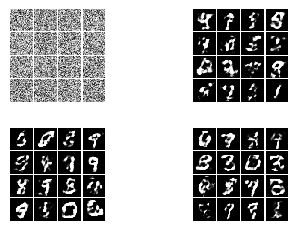

In [13]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-WGAN-GP/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-WGAN-GP/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-WGAN-GP/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-WGAN-GP/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

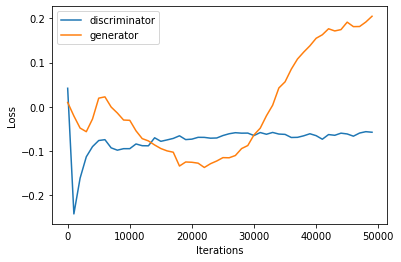

In [14]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['discriminator']))*1000, avg_costs['discriminator'], label='discriminator')
plt.plot(np.arange(len(avg_costs['generator']))*1000, avg_costs['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()